# Formato de datos

En esta notebook vamos a jugar con diferentes fuentes de datos, recordando cómo cargar y acceder a distintos tipos de datos.

En particular, vamos a ver:

*   Obtener archivos desde una url.
*   Acceder y recorrer un archivo ``.csv``.
*   Acceder y recorrer un archivo ``.xml``.
*   Acceder al contenido de un archivo ``.zip``.
*   Acceder y recorrer un archivo ``.json``.

In [ ]:
import functools
import pathlib
import shutil
import requests
from tqdm.auto import tqdm as tqdmauto
import requests
import os

### Obtener archivos desde una url

Por ejemplo, para acceder al contenido de la página de Wikipedia correspondiente a Londres, podemos hacer:

In [ ]:
data = requests.get('https://en.wikipedia.org/wiki/London')
content = data.content

print(content)

Sin embargo, eso no nos permite guardar el contenido en un archivo. En el caso en que querramos guardar el archivo que estamos accediendo (por ejemplo, un archivo almacenado en un GitHub). Vamos a tomar como ejemplo un archivo ``.csv`` que se encuentra en GitHub y que contiene un dataset para la detección de Hate Speech.

Vamos a agregar un método auxiliar para realizar las descargar y observar el progreso:

In [ ]:
def download_file(url, filename):    
    r = requests.get(url, stream=True, allow_redirects=True)
    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
    file_size = int(r.headers.get('Content-Length', 0))

    path = pathlib.Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    desc = "(Unknown total file size)" if file_size == 0 else ""
    r.raw.read = functools.partial(r.raw.read, decode_content=True)  # Decompress if needed
    with tqdmauto.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)

    return path

In [ ]:
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
datapath = "labeled_data.csv" # se puede incluir estructura de carpetas

download_file(url,datapath)

Notar que al no haber vinculado la notebook a nuestra cuenta de Drive, los archivos serán descargados en el espacio asignado a la notebook, accesible haciendo click en la carpetita que aparece en la barra de menú vertical de la izquierda. En consecuencia, el tiempo de persistencia de estos archivos será el mismo que el de vida de la notebook.

### Acceder y recorrer un archivo ``.csv`` 

Los archivos ``.csv`` pueden ser directamente almacenados en un ``DataFrame`` de ``pandas``. 
Para ello, solo es necesario definir la ubicación del archivo y las columnas de dicho archivo a utilizar. Por ejemplo, considerando el ``.csv`` que descargamos anteriormente, vamos a quedarnos con las columnas ``class`` y ``tweet``.

In [ ]:
import pandas as pd

In [ ]:
url = "labeled_data.csv"
df = pd.read_csv(url,usecols=['class', 'tweet']) # de todas las columnas que tiene el dataset, nos vamos a quedar solo con el texto y la clase

df

En el ejemplo anterior utilizamos el archivo que habíamos descargado previamente, sin embargo, ``pandas`` también soporta que se le pase una ``url`` como parámetro. Entonces, si quisieramos cargar los datos del mismo archivo, pero sin tenerlo previamente descargado, podríamos hacer:

In [ ]:
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url, usecols=['class', 'tweet']) # de todas las columnas que tiene el dataset, nos vamos a quedar solo con el texto y la clase

df

Si quisiéramos, en lugar de delegar la conversión de los records del ``.csv`` en ``pandas``, podríamos recorrerlo y procesarlo de forma manual utilizando 

In [ ]:
import csv

In [ ]:
reader = csv.DictReader(open("labeled_data.csv"))

with open('labeled_data.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    print("header: ",reader.fieldnames)
    next(csvreader) # salteando el header
    for row in csvreader:
            print('-',row[6].replace('\n','')) # accedemos al texto del tweet

### Acceder y recorrer un archivo ``.xml``

El XML es un formato de intercambio de datos que cuenta con algunas reglas para la definición de su estructura en forma de árbol.

*   Puede incluir al principio una declaración (denominada prolog) la cual define el encoding utilizado en el documento.
*   Debe tener un único elemento raíz,el cual es el padre de todos los otros elementos.
*   Todos los elementos se encuentran encerrados entre tags. Si se incluyó un tag de inicio, debe incluirse el tag de finalización. Por ejemplo, en ``<p> texto <\p>``, el ``<\p>`` es obligatorio.
*    Los tags son case sensitive. Por ejemplo ``<mensaje>`` es distinto de ``<Mensaje>``.
*    Los elementos deben encontrarse apropiadamente anidados. Por ejemplo: ``<b><i> Texto </i></b>`` no puede escribirse como ``<b><i> Texto </b></i>``.
*    Los atributos deben estar siempre entre comillas.
*    Algunos chars tienen significado especial y deben ser reemplazados por lo que llaman un "entity reference". Por ejemplo: ``<mensaje> cantidad < 10 </mensaje>`` dará error, dado que el ``<`` será interpretado como un inicio de tag. En su lugar, debe utilizarse ``&lt;``.
*    Se permiten comentarios.
*    Se preservan los espacios.

En este caso, vamos a ejemplificar utilizando un reporte extraído de Jira para el proyecto ``Apache Camel``.

In [ ]:
url = "https://drive.google.com/uc?export=download&id=1iHve6u13LMrPYuOZZedSuhgMk6ZOEkXr"
datapath = "CAMEL-15233.xml"

In [ ]:
download_file(url,datapath)

Esta forma de descargar archivos de Drive no suele tener problemas cuando el tamaño no supera los 100MB. Cuando tenemos que bajar archivos más grandes, se puede utilizar ``gdown``. Asimismo, también puede tener problemas si drive "detecta" que puede ser un archivo peligroso. Si no está instalada, primero ejecutar:

In [ ]:
pip install gdown

In [ ]:
import gdown

gdown.download(url, datapath, quiet=False)

Hay distintos tipos de parsers, en este caso vamos a utilizar la opción de [``ElementTree``](https://docs.python.org/3.4/library/xml.etree.elementtree.html).

In [ ]:
import xml.etree.ElementTree as ET 

In [ ]:
# create element tree object 
tree = ET.parse(datapath) 
  
# get root element 
root = tree.getroot()

item = root.findall("channel")[0].findall("item")[0] # sabemos que hay solo uno

print("Title: ",item.find("title").text) # es un child, no un atributo
print("Type: ",item.find("type").text) # es un child, no un atributo
print("Priority: ",item.find("priority").text) # es un child, no un atributo

comments = item.find("comments")
for comment in comments.findall("comment"):
  print("Comment: ",comment.attrib["author"]) # accedemos a un atributo del comentario
  print(" ",comment.text)

### Acceder al contenido de un archivo ``.zip``

En este caso, vamos a descargar y extraer el contenido de un archivo ``.zip`` conteniendo tweets.

In [ ]:
# descargamos el archivo invocando a la función que definimos anteriormente

url = "https://drive.google.com/uc?export=download&id=1RCNlZXFpTBAisF2Bsh2OJl7g4qLnR3vI"

datapath = "sydneysiege-example.zip"
download_file(url,datapath)

In [ ]:
import gdown

gdown.download(url, datapath, quiet=False)

Una vez descargado el ``.zip``, hay que descomprimirlo.

In [ ]:
import gzip
import shutil

from zipfile import ZipFile
 
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
    zipObj.extractall('.')

Ahora podemos ver en el espacio de la notebook, que se descomprimió el archivo y podemos acceder a los diferentes directorios.

Vamos a ver una estructura anidada de directorios, donde hay archivos correspondientes a tweets y sus reacciones.

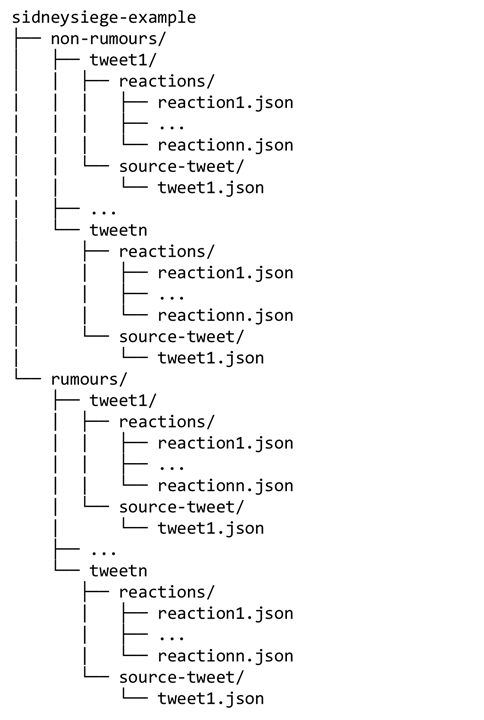

In [ ]:
path = os.walk("sydneysiege-example")

for root, directories, files in path:
    for directory in directories:
        print(directory)
    for file in files:
        print(root,file)

### Acceder y recorrer un archivo ``.json``

La estructura de los archivos ``.json`` se define con:

*   Los datos se definen como pares ``objeto : valor``. 
*   Los objetos están separados por ``,``.
*   Los objetos se encierran entre ``{}``.
*   Los objetos pueden ser agrupados en secuencias ordenadas encerradas entre ``[]``. Por ejemplo ``[{},{}]``.
*   Los elementos deben estar encerrados entre comillas, a menos que representen elementos numéricos.

El siguiente ejemplo representa un objeto simple, sin anidamientos:

```
{ "name":"Chaya", "age":12, "city":"Boulder", "type":"Canine" }
```

Considerando una estructura un poco más compleja incluyendo anidamientos:

```
{
     "album_title" : "Yellow Submarine",     
     "release_year" : 1966,   
     "won_grammy" : False,
     "band" : "The Beatles",
     "album_sale": None
     "musicians" : ["John Lennon", "Paul McCartney", "George   Harrison", "Ringo Starr"],
     "studio" : {"studio_name": "Abbey Road Studios", "location": "London, England"}
     }
```

En este caso vamos a trabajar con un archivo correspondiente a un tweet de los que estaban en el ``.zip`` que descomprimimos anteriormente.


Al igual que con el ``.csv``, los ``.json`` pueden ser directamente cargados en un ``DataFrame`` de ``pandas``.

In [ ]:
datapath = "./sydneysiege-example/non-rumours/544266241511133186/source-tweet/544266241511133186.json"
jsondf = pd.read_json(datapath)

print(jsondf.columns)
jsondf

Pero, fíjense que la carga de forma directa no nos da como resultado lo que nosotros esperábamos. El ``.json`` que seleccionamos incluye un único tweet con todos sus atributos. Con lo que hubiésemos esperado obtener una fila con muchas columnas. Es necesario modificar la orientación para la carga del dataframe.

In [ ]:
jsondf = pd.read_json(datapath,orient="index").T
jsondf = jsondf.set_index('id') # seteamos el id como index del frame
jsondf

In [ ]:
print("Columns: ",jsondf.columns)
print("Rows: ",jsondf.index.values)

print("Text: ",jsondf['text']) #accedemos al texto (para todas las filas)

print("Entities: ",jsondf['entities']) # fíjense en este caso, que la estructura compleja la parseó como un dict, con lo que se puede acceder de forma directa

for row in jsondf['entities']:
    print(row)
    print("Hashtags: ",row['hashtags'])

Si quisiéramos, el ``.json`` podríamos parsearlo de forma directa:

In [ ]:
import json

In [ ]:
with open(datapath) as json_file:
    data = json.load(json_file)
    print(data)
    for x in data: # iteramos por todos los keys
        print(x,":",data[x]) # accedemos a los datos

En caso de que se trate de un arreglo de objetos json.

In [ ]:
array = '[\
    { "name":"Ford", "models":[ "Fiesta", "Focus", "Mustang" ] },\
    { "name":"BMW", "models":[ "320", "X3", "X5" ] },\
    { "name":"Fiat", "models":[ "500", "Panda" ] }\
  ]' # fíjense que las propiedades y valores están entre comillas dobles.

In [ ]:
jarray = json.loads(array)
for js in jarray: # iteramos por cada uno de los objetos
    print(js) # accedemos a los datos de cada objeto

Para cargar un ``jsonarray`` en un dataframe, no hay que hacer nada especial, dado que pandas acepta como parámetro del constructor una lista de diccionarios:

In [ ]:
listi = [x for x in jarray] # primero armamos
pd.DataFrame(jarray)